In [ ]:
# Name: Jonathan Ojangole
# SN: 101209177

!pip install nlp
!pip install datasets

In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.15.0


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataframe. Dataset from hugging face tweet emotion data
dataset = pd.read_pickle("merged_training.pkl")

# Split the dataframe into train, val, and test
train, temp = train_test_split(dataset, test_size=0.3, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)

# Print the shapes of the train, val, and test dataframes
print(f"Train shape: {train.shape}")
print(f"Validation shape: {val.shape}")
print(f"Test shape: {test.shape}")


Train shape: (291766, 2)
Validation shape: (62521, 2)
Test shape: (62522, 2)


In [ ]:
dataset

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love
...,...,...
566,that was what i felt when i was finally accept...,joy
36236,i take every day as it comes i m just focussin...,fear
76229,i just suddenly feel that everything was fake,sadness
131640,im feeling more eager than ever to claw back w...,joy


In [ ]:
def get_tweet(df):
    # Extract the 'text' and 'emotions' columns and convert them to lists
    tweets = df['text'].tolist()
    labels = df['emotions'].tolist()

    return tweets, labels

In [ ]:
#testing
tweets, labels = get_tweet(train)
tweets[1], labels[1]

('i feel a bit gloomy and sad', 'sadness')

In [ ]:
#tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [ ]:
#testing
tokenizer.texts_to_sequences([tweets[0]])

[[2,
  3,
  9,
  13,
  57,
  27,
  592,
  1640,
  78,
  57,
  706,
  51,
  114,
  62,
  1306,
  400,
  4,
  55,
  5,
  354,
  1220,
  9,
  228,
  400]]

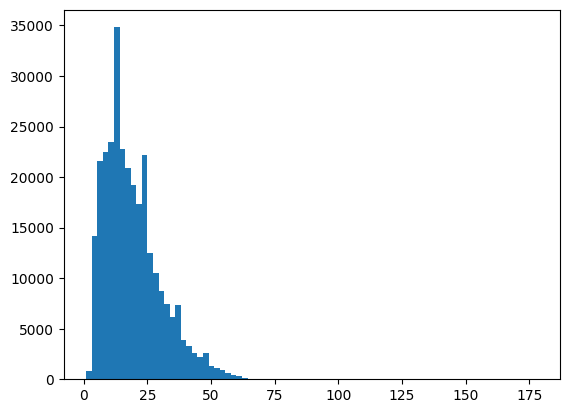

In [ ]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [ ]:
maxlen = 50
# padding
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [ ]:
#testing
padded_train_seq = get_sequences(tokenizer, tweets)
padded_train_seq[0]

array([   2,    3,    9,   13,   57,   27,  592, 1640,   78,   57,  706,
         51,  114,   62, 1306,  400,    4,   55,    5,  354, 1220,    9,
        228,  400,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
#preparing the labels
classes = set(labels)
print(classes)

{'fear', 'sadness', 'surprise', 'anger', 'love', 'joy'}


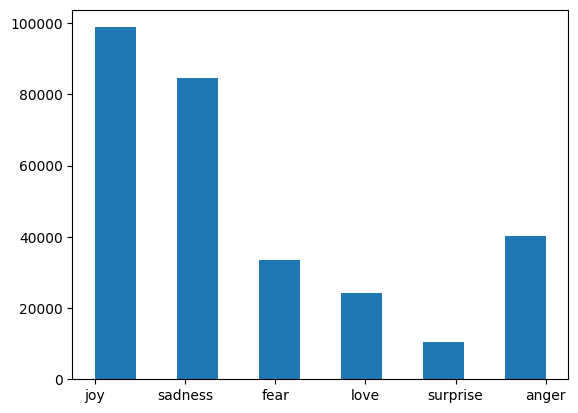

In [ ]:
plt.hist(labels, bins=11)
plt.show()

In [ ]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [ ]:
class_to_index

{'fear': 0, 'sadness': 1, 'surprise': 2, 'anger': 3, 'love': 4, 'joy': 5}

In [ ]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])
train_labels = names_to_ids(labels)
print(train_labels[0])

5


In [ ]:
# creating the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 50, 40)            5920      
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175926 (687.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#prepare validation data
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

#testing
val_tweets[0], val_labels[0]

#Train the model
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
)

Epoch 1/20
9118/9118 [==============================] - 175s 18ms/step - loss: 0.3049 - accuracy: 0.8732 - val_loss: 0.1436 - val_accuracy: 0.9275
Epoch 2/20
9118/9118 [==============================] - 138s 15ms/step - loss: 0.1164 - accuracy: 0.9346 - val_loss: 0.1165 - val_accuracy: 0.9348
Epoch 3/20
9118/9118 [==============================] - 138s 15ms/step - loss: 0.1001 - accuracy: 0.9394 - val_loss: 0.1014 - val_accuracy: 0.9374
Epoch 4/20
9118/9118 [==============================] - 137s 15ms/step - loss: 0.0944 - accuracy: 0.9407 - val_loss: 0.0952 - val_accuracy: 0.9383
Epoch 5/20
9118/9118 [==============================] - 136s 15ms/step - loss: 0.0916 - accuracy: 0.9422 - val_loss: 0.0962 - val_accuracy: 0.9367
Epoch 6/20
9118/9118 [==============================] - 146s 16ms/step - loss: 0.0882 - accuracy: 0.9425 - val_loss: 0.0970 - val_accuracy: 0.9354


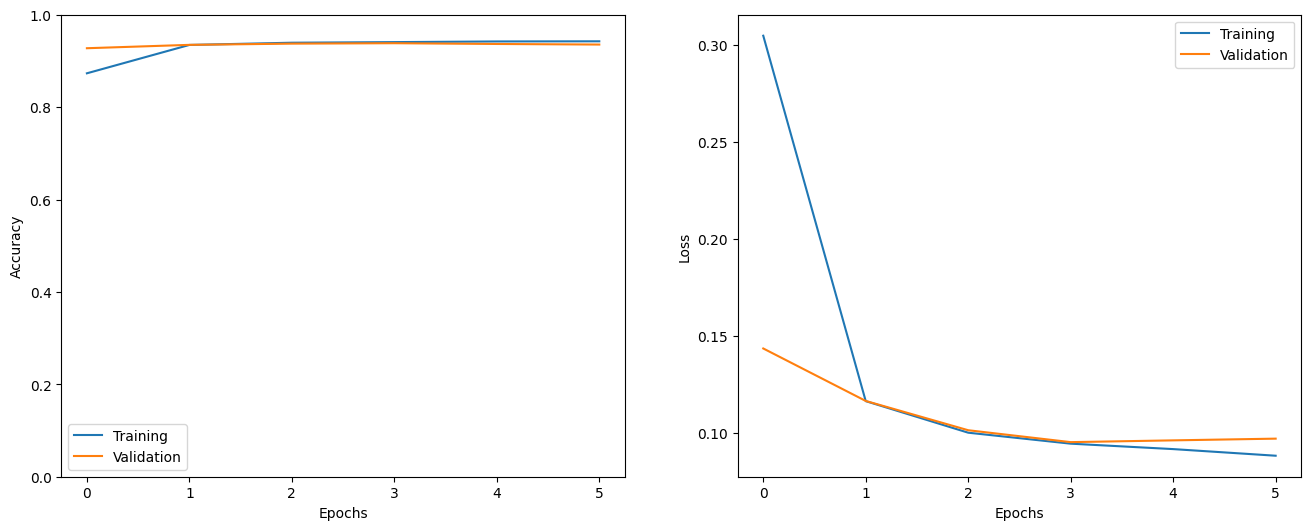

In [ ]:
#evaluating the model
show_history(h)

In [ ]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
_=model.evaluate(test_seq,test_labels)

1954/1954 [==============================] - 13s 6ms/step - loss: 0.0984 - accuracy: 0.9346


In [ ]:
#testing
i = random.randint(0, len(test_labels)-1)
print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Emotion:', pred_class)

In [ ]:
preds = model.predict(test_seq)

predicted_class = np.argmax(preds, axis=1)
print('Predicted class:', predicted_class)

1954/1954 [==============================] - 12s 6ms/step
Predicted class: [1 1 5 ... 1 0 1]


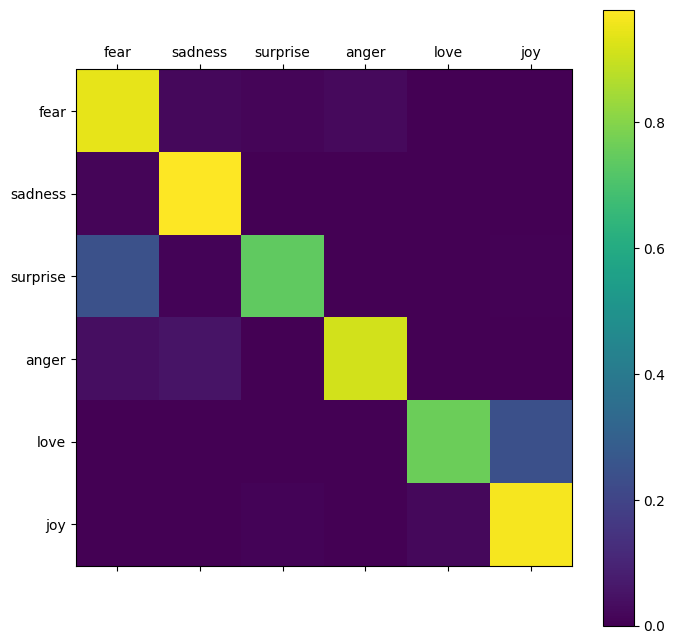

In [ ]:
show_confusion_matrix(test_labels, predicted_class, list(classes))